In [1]:
import os
import time
import copy
import random
from collections import defaultdict

import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from torch.nn import MultiMarginLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
IMG_H = 256
IMG_W = 256

DATA_DIR = '../data/resampled_png/'

EPOCHS = 10
BATCH_SIZE = 96
NUM_WORKERS = 8

## Convert from .bmp to .jpg

In [3]:
# def bmp_to_jpg(root_dir, save_path):
#     data_path = os.path.join(root_dir)
#     for class_dir in os.listdir(data_path):
#         to_class_path = os.path.join(data_path, class_dir)
#         os.makedirs(f'{save_path}{class_dir}/')
#         for f_name in os.listdir(to_class_path):
#             f_path = os.path.join(to_class_path, f_name)
#             img = Image.open(f_path)
#             new_img = img.resize((IMG_H, IMG_W))
#             f_new_name = f_name.split('.')
#             new_img.save(f'{save_path}{class_dir}/{f_new_name[0]}.png', 'png')

In [4]:
# bmp_to_jpg('../data/resampled/', DATA_DIR)

## Augmentation and preparation

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
images_filepaths = []
class_names = {}
counter = 0
for class_name in os.listdir(DATA_DIR):
    if class_name not in class_names:
        class_names[class_name] = float(counter)
        counter += 1
    class_dir = os.path.join(DATA_DIR, class_name)
    for f in os.listdir(class_dir):
        images_filepaths.append(os.path.join(class_dir, f))
len(images_filepaths)

1495

In [7]:
class_names

{'Нормобласты': 0.0, 'Сегментноядерный нейтрофил': 1.0, 'Бласты': 2.0}

In [8]:
random.seed(42)
random.shuffle(images_filepaths)

test_size = int(len(images_filepaths) * 0.1)
train_size = int((len(images_filepaths) - test_size) * 0.8)

train_images_filepaths = images_filepaths[:train_size]
val_images_filepaths = images_filepaths[train_size:-test_size]
test_images_filepaths = images_filepaths[-test_size:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

1076 270 149


In [9]:
class Cells(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(image/255)
        
        class_name = image_filepath.split(sep='/')[-2]
        label = class_names[class_name]
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [10]:
# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(),
    ToTensorV2(),
])

In [11]:
train_dataset = Cells(train_images_filepaths, transform)
val_dataset = Cells(val_images_filepaths, transform)

In [12]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()   

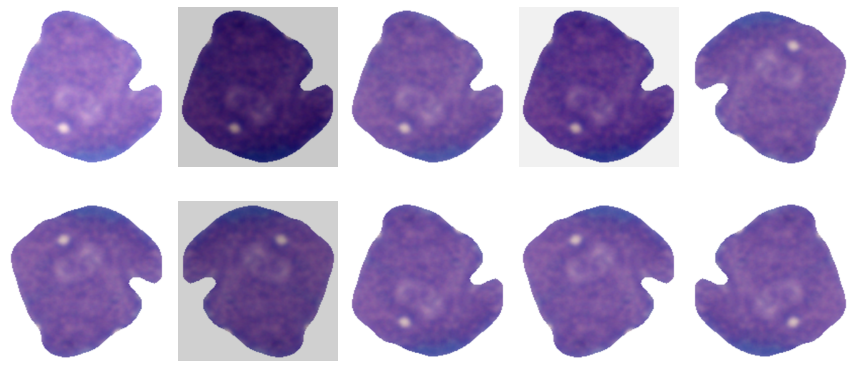

In [13]:
random.seed(42)
visualize_augmentations(train_dataset)

In [14]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [15]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,
)

## Train and validation

In [16]:
model = models.resnet18(num_classes=len(class_names))
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
# def calculate_accuracy(output, target):
# #     _,output = torch.max(output, dim = 1)
# #     correct = (output == target.view(1, -1) )
# #     return correct.sum() / len(correct)
#     _,output = torch.max(output, dim = 1)
#     output = torch.sigmoid(output) >= 0.5
#     target = target == 1.0
#     return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [18]:
def train(train_loader, model, criterion, optimizer, epoch):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_corrects = 0
    for i, (images, target) in enumerate(stream, start=1):
        # Prepare batch
        X = images.to(device, non_blocking=True)
        y = target.to(device, non_blocking=True).long()
        y_preds = model(X)
        
        # Check loss
        loss = criterion(y_preds, y)
        
        # Check accuracy
        _,y_preds = torch.max(y_preds, dim = 1)
        running_corrects += torch.sum(y_preds == y.view(1, -1))
        accuracy = running_corrects.double() / len(train_loader)
        
        # Show metrics
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch+1, metric_monitor=metric_monitor)
        )

In [19]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_corrects = 0 
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            X = images.to(device, non_blocking=True)
            y = target.to(device, non_blocking=True).long()
            y_preds = model(X)
            loss = criterion(y_preds, y)
            _,y_preds = torch.max(y_preds, dim = 1)
            running_corrects += torch.sum(y_preds == y.view(1, -1))
            accuracy = running_corrects.double() / len(val_loader)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch+1, metric_monitor=metric_monitor)
            )

In [20]:
for epoch in range(EPOCHS):
    train(train_loader, model, criterion, optimizer, epoch)
    validate(val_loader, model, criterion, epoch)

Epoch: 1. Train.      Loss: 0.471 | Accuracy: 37.951: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]
Epoch: 1. Validation. Loss: 3.863 | Accuracy: 20.444: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]
Epoch: 2. Train.      Loss: 0.206 | Accuracy: 47.569: 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]
Epoch: 2. Validation. Loss: 2.877 | Accuracy: 23.444: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]
Epoch: 3. Train.      Loss: 0.199 | Accuracy: 48.333: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]
Epoch: 3. Validation. Loss: 0.737 | Accuracy: 48.333: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Epoch: 4. Train.      Loss: 0.179 | Accuracy: 48.674: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]
Epoch: 4. Validation. Loss: 0.570 | Accuracy: 54.222: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]
Epoch: 5. Train.      Loss: 0.166 | Accuracy: 48.528: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]
Epoch: 5. Validation. Loss: 0.349 | Accuracy: 56.778: 100%|██████████| 3/3 [00:01<00:00,  

## Testing

In [30]:
class CellsInference(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(image/255)
        
        class_name = image_filepath.split(sep='/')[-2]
        label = class_names[class_name]

        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

test_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RandomGamma(),
        ToTensorV2(),
    ]
)
test_dataset = CellsInference(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
)

In [31]:
# prepare to count predictions for each class
model = model.eval()
swap_class_names = dict([(value, key) for key, value in class_names.items()])
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[swap_class_names[label.item()]] += 1
            total_pred[swap_class_names[label.item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Нормобласты is: 92.0 %
Accuracy for class Сегментноядерный нейтрофил is: 93.0 %
Accuracy for class Бласты is: 98.2 %


In [32]:
total_accuracy = 0
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    total_accuracy += accuracy
print("Total accuracy on all classes is {:.1f} %".format(total_accuracy/ len(swap_class_names)))

Total accuracy on all classes is 94.4 %
